In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import statsmodels.api as sm

from scipy.stats import pearsonr
from statsmodels.tsa.api import VAR

warnings.filterwarnings("ignore")

In [3]:
data = pd.read_excel('../../data/market_data.xlsx')

In [3]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63457 entries, 0 to 63456
Data columns (total 13 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   Time (UTC+10)                                           63457 non-null  datetime64[ns]
 1   Regions NSW Trading Price ($/MWh)                       63457 non-null  float64       
 2   Regions SA Trading Price ($/MWh)                        63457 non-null  float64       
 3   Regions TAS Trading Price ($/MWh)                       63457 non-null  float64       
 4   Regions VIC Trading Price ($/MWh)                       63457 non-null  float64       
 5   Regions NSW Trading Total Intermittent Generation (MW)  63457 non-null  float64       
 6   Regions SA Trading Total Intermittent Generation (MW)   63457 non-null  float64       
 7   Regions TAS Trading Total Intermittent Generation (MW)  63

In [4]:
training = data.loc[(data['Time (UTC+10)'] >= '2018-01-01') &
                            (data['Time (UTC+10)'] < '2021-01-01')]

In [5]:
training_vic = training[['Time (UTC+10)', 
                         'Regions VIC Trading Price ($/MWh)',
                         'Regions VIC Trading Total Intermittent Generation (MW)',
                         'Regions VIC Operational Demand (MW)']]

training_tas = training[['Time (UTC+10)', 
                         'Regions TAS Trading Price ($/MWh)',
                         'Regions TAS Trading Total Intermittent Generation (MW)',
                         'Regions TAS Operational Demand (MW)']]

training_sa = training[['Time (UTC+10)', 
                         'Regions SA Trading Price ($/MWh)',
                         'Regions SA Trading Total Intermittent Generation (MW)',
                         'Regions SA Operational Demand (MW)']]

training_nsw = training[['Time (UTC+10)', 
                         'Regions NSW Trading Price ($/MWh)',
                         'Regions NSW Trading Total Intermittent Generation (MW)',
                         'Regions NSW Operational Demand (MW)']]

In [6]:
def plot_series(x, y, title, xlabel, ylabel):
    plt.plot(x, y)
    plt.title(title, fontsize = 16)
    plt.xticks(['2018-01-01 00:00:00','2019-01-01 00:00:00', '2020-01-01 00:00:00'], ['2018','2019','2020'])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    for year in range(2018, 2021):
        plt.axvline(datetime.datetime(year,1,1), linestyle = '--', color = 'k', alpha = 0.5)

    plt.show()

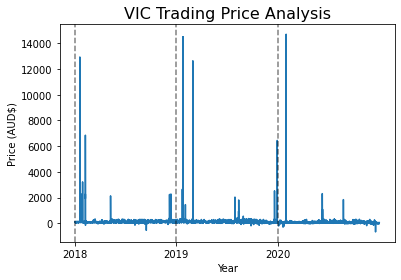

In [7]:
plot_series(training_vic['Time (UTC+10)'], 
            training_vic['Regions VIC Trading Price ($/MWh)'],
            'VIC Trading Price Analysis', 
            'Year',
            'Price (AUD$)')

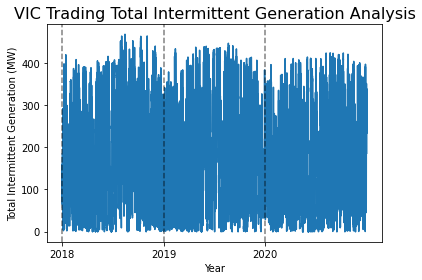

In [8]:
plot_series(training_vic['Time (UTC+10)'], 
            training_vic['Regions VIC Trading Total Intermittent Generation (MW)'],
            'VIC Trading Total Intermittent Generation Analysis', 
            'Year',
            'Total Intermittent Generation (MW)')

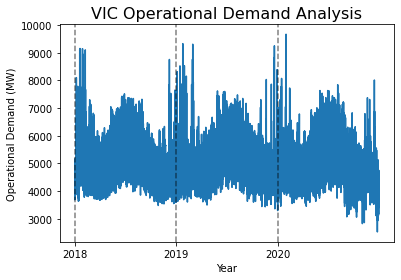

In [9]:
plot_series(training_vic['Time (UTC+10)'], 
            training_vic['Regions VIC Operational Demand (MW)'],
            'VIC Operational Demand Analysis', 
            'Year',
            'Operational Demand (MW)')

### NORMALIZE

In [6]:
def normalize(series):
    mean = series.mean()
    std_dev = series.std()
    result = (series - mean) / std_dev
    return result

In [7]:
# Normalize all data
for column in training_vic.columns:
    if (column != 'Time (UTC+10)'):
        training_vic[column] = normalize(training_vic[column])

In [8]:
plot_series(training_vic['Time (UTC+10)'], 
            training_vic['Regions VIC Trading Price ($/MWh)'],
            'VIC Trading Price Analysis', 
            'Year',
            'Price (AUD$)')

NameError: name 'plot_series' is not defined

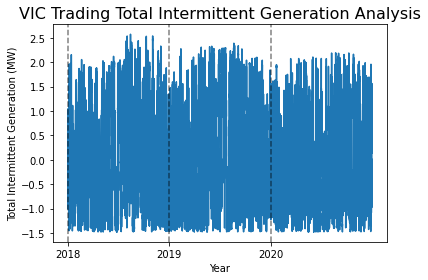

In [13]:
plot_series(training_vic['Time (UTC+10)'], 
            training_vic['Regions VIC Trading Total Intermittent Generation (MW)'],
            'VIC Trading Total Intermittent Generation Analysis', 
            'Year',
            'Total Intermittent Generation (MW)')

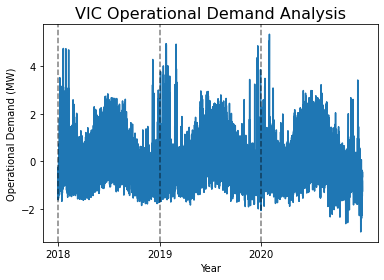

In [14]:
plot_series(training_vic['Time (UTC+10)'], 
            training_vic['Regions VIC Operational Demand (MW)'],
            'VIC Operational Demand Analysis', 
            'Year',
            'Operational Demand (MW)')

### REMOVE SEASONALITY 

In [9]:
training_vic = training_vic.set_index('Time (UTC+10)')

In [10]:
def remove_seasonality(df, series):
    month_avg = df[series].groupby(df[series].index.month).mean()
    month_avg_series = df[series].index.map(lambda x: month_avg.loc[x.month])
    result = df[series] - month_avg_series
    return result

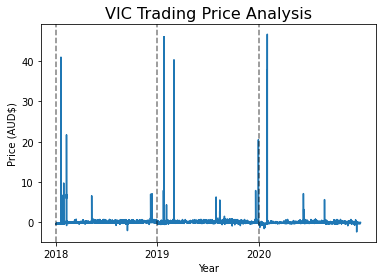

In [17]:
# VIC Trading Price
series = 'Regions VIC Trading Price ($/MWh)'
training_vic[series] = remove_seasonality(training_vic, series)

plot_series(training_vic.index, 
            training_vic['Regions VIC Trading Price ($/MWh)'],
            'VIC Trading Price Analysis', 
            'Year',
            'Price (AUD$)')

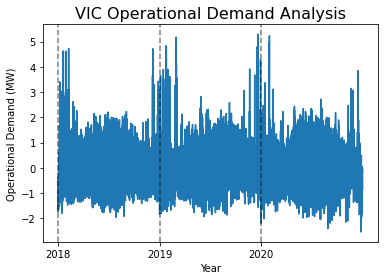

In [18]:
# VIC Operational Demand
series = 'Regions VIC Operational Demand (MW)'
training_vic[series] = remove_seasonality(training_vic, series)

plot_series(training_vic.index, 
            training_vic['Regions VIC Operational Demand (MW)'],
            'VIC Operational Demand Analysis', 
            'Year',
            'Operational Demand (MW)')

### Partial Autocorrelation Funciton (PACF) on VIC Trading Price

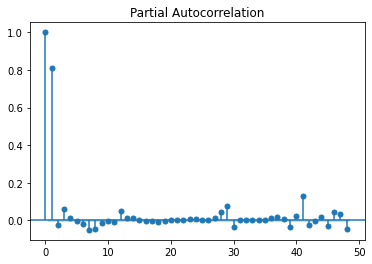

In [11]:
sm.graphics.tsa.plot_pacf(training_vic['Regions VIC Trading Price ($/MWh)'])
plt.show()

Observe that PACF declines at Lag 1

### Correlation between VIC Trading Price and VIC Trading Total Intermittent Generation

In [20]:
for lag in range(1, 50):
    lag_TP_vic = training_vic['Regions VIC Trading Price ($/MWh)'].iloc[lag:]
    lag_TIG_vic = training_vic['Regions VIC Trading Total Intermittent Generation (MW)'].iloc[:-lag]
    print("Lag:" + str(lag))
    print(pearsonr(lag_TP_vic, lag_TIG_vic))
    print("\n")

Lag:1
(-0.05429416337284791, 1.2043182874643505e-35)


Lag:2
(-0.0517936234951885, 1.38151868560471e-32)


Lag:3
(-0.049188957883930615, 1.4967608022073983e-29)


Lag:4
(-0.04700495099277945, 3.984449249850771e-27)


Lag:5
(-0.044348016831300574, 2.534285085365038e-24)


Lag:6
(-0.041622473299554444, 1.2959853767846614e-21)


Lag:7
(-0.03857118438039925, 8.803191610909747e-19)


Lag:8
(-0.035453775166156304, 4.1680510050449416e-16)


Lag:9
(-0.03283177275231073, 5.01050208894639e-14)


Lag:10
(-0.029984699700107878, 6.063475156795081e-12)


Lag:11
(-0.0271393006335987, 4.811399115686543e-10)


Lag:12
(-0.024181175572347197, 2.9170152925985392e-08)


Lag:13
(-0.021704418194514574, 6.422061617731694e-07)


Lag:14
(-0.019550812339162678, 7.326201967271313e-06)


Lag:15
(-0.01809159765975514, 3.3361494893130465e-05)


Lag:16
(-0.016301081385029063, 0.00018513793580214632)


Lag:17
(-0.014822381884720508, 0.000675629161875701)


Lag:18
(-0.013534467809577105, 0.0019101271467255924)


Lag:19

### Correlation between VIC Trading Price and VIC Operational Demand

In [21]:
for lag in range(1, 25):
    lag_TP_vic = training_vic['Regions VIC Trading Price ($/MWh)'].iloc[lag:]
    lag_TIG_vic = training_vic['Regions VIC Operational Demand (MW)'].iloc[:-lag]
    print("Lag:" + str(lag))
    print(pearsonr(lag_TP_vic, lag_TIG_vic))
    print("\n")

Lag:1
(0.21373007683444767, 0.0)


Lag:2
(0.2039169748649176, 0.0)


Lag:3
(0.19259954393683099, 0.0)


Lag:4
(0.1803964866343991, 0.0)


Lag:5
(0.16731503951470045, 0.0)


Lag:6
(0.1545045246988737, 2.422983395358749e-278)


Lag:7
(0.1421019607129905, 2.451356456340192e-235)


Lag:8
(0.12971072150727392, 4.242357281933547e-196)


Lag:9
(0.11825019850132562, 4.322871727824203e-163)


Lag:10
(0.10777368360754394, 1.1860507378188291e-135)


Lag:11
(0.09812467103332798, 1.1241879305162192e-112)


Lag:12
(0.08888583871543887, 1.0053003487797083e-92)


Lag:13
(0.08042669046927514, 3.329530137994215e-76)


Lag:14
(0.07295893047717276, 5.304843783642984e-63)


Lag:15
(0.06606124371997224, 5.926018481898426e-52)


Lag:16
(0.05999588773883636, 3.814181880847693e-43)


Lag:17
(0.055046138116026724, 1.3912965453736705e-36)


Lag:18
(0.05052496698432879, 4.43175764715744e-31)


Lag:19
(0.046130050441712256, 3.5330746293774054e-26)


Lag:20
(0.04152131520719067, 1.641230375755318e-21)


Lag:21
(0.0

### Vector Autoregression Model (VAR) 

In [12]:
vic_training = training_vic[['Regions VIC Trading Price ($/MWh)',
                             'Regions VIC Trading Total Intermittent Generation (MW)',
                             'Regions VIC Operational Demand (MW)']]

In [13]:
model = VAR(vic_training)
x = model.select_order(maxlags = 24)
x.summary()

,AIC,BIC,FPE,HQIC
0,-0.04999,-0.04949,0.9512,-0.04984
1,-8.400,-8.398,0.0002248,-8.400
2,-9.588,-9.584,6.857e-05,-9.586
3,-9.602,-9.596,6.763e-05,-9.600
4,-9.604,-9.597,6.746e-05,-9.602
5,-9.616,-9.607,6.668e-05,-9.613
6,-9.618,-9.609,6.649e-05,-9.615
7,-9.622,-9.611,6.627e-05,-9.618
8,-9.625,-9.612,6.607e-05,-9.621
9,-9.626,-9.612,6.599e-05,-9.622


In [19]:
model = VAR(vic_training)
model = model.fit(20)
model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 10, Oct, 2021
Time:                     11:20:05
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -9.64814
Nobs:                     52588.0    HQIC:                  -9.66936
Log likelihood:           30825.4    FPE:                6.25836e-05
AIC:                     -9.67901    Det(Omega_mle):     6.23663e-05
--------------------------------------------------------------------
Results for equation Regions VIC Trading Price ($/MWh)
                                                                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------------------------------
const                                                             -0.000014         0.002534           -

In [16]:
training_vic.values[-20:]

array([[-0.30214021,  0.5358452 , -1.22938007],
       [-0.29416921,  0.63661842, -1.16182297],
       [-0.32219627,  0.56655292, -1.06165211],
       [-0.27797009,  0.60444019, -0.94517435],
       [-0.27777724,  0.95961173, -0.80540105],
       [-0.25981036,  1.23355919, -0.64466176],
       [-0.19314967,  1.27931802, -0.47227468],
       [-0.24065425,  1.45128125, -0.44315525],
       [-0.24075067,  1.45906631, -0.43733136],
       [-0.2015385 ,  1.34107946, -0.49091112],
       [-0.15914437,  1.16920273, -0.52934878],
       [-0.14413446,  0.92518449, -0.57710466],
       [-0.14374877,  0.73825665, -0.60272976],
       [-0.15216974,  0.86999709, -0.60971843],
       [-0.15657308,  0.98893544, -0.69241763],
       [-0.15692663,  1.08235611, -0.76113951],
       [-0.15551242,  0.88920023, -0.84034438],
       [-0.11450035,  0.44493305, -0.8752877 ],
       [-0.14532368,  0.16769857, -0.86713426],
       [-0.10839354,  0.13413633, -0.63883787]])

In [20]:
model.forecast(training_vic.values[-20:],steps=10)

array([[-0.03977575,  0.1111386 , -0.43564705],
       [ 0.00449904,  0.07254882, -0.29180845],
       [ 0.02504721,  0.03683357, -0.16988562],
       [ 0.06034185,  0.01375344, -0.05835108],
       [ 0.06718679, -0.00227214,  0.02771897],
       [ 0.06546478, -0.01288038,  0.09716341],
       [ 0.08218859, -0.02389835,  0.14609749],
       [ 0.10139911, -0.03741059,  0.17577461],
       [ 0.09100297, -0.0559037 ,  0.16451443],
       [ 0.07769854, -0.06465914,  0.13492895]])